# ETL

In [2]:
# Load library
import pandas as pd

In [3]:
# Load dataset and save memory, improve speed

# select columns to use
cols_to_use = ["Summons Number", "Plate", "State", "License Type", "Issue Date", "Violation Time", "Violation", "Fine Amount", "Amount Due", "Precinct", "County", "Issuing Agency"]

# input data type map
dtype_map = {
    "Summons Number": "int64",
    "Plate": "category",
    "State": "category",
    "License Type": "category",
    "Violation Time": "string",
    "Violation": "category",
    "Fine Amount": "float32",
    "Amount Due": "float32",
    "Precinct": "int64",
    "County": "category",
    "Issuing Agency": "category"
    # do not include 'Issue Date' here - included in parse_dates command
}

# Load the CSV using a relative path
df = pd.read_csv("data/Open_Parking_and_Camera_Violations_2024.csv",
                 usecols=cols_to_use,
                 dtype=dtype_map,
                 low_memory=False,
                 parse_dates=["Issue Date"],
                 dayfirst=False  # important if format is MM/DD/YYYY)
                )

# Preview the first few rows
df.head()

,Plate,State,License Type,Summons Number,Issue Date,Violation Time,Violation,Fine Amount,Amount Due,Precinct,County,Issuing Agency
0,T626964C,NY,OMT,5137042444,09/08/2024,04:10P,FAILURE TO STOP AT RED LIGHT,50.0,0.0,0,QN,DEPARTMENT OF TRANSPORTATION
1,LDA5100,NY,PAS,4882492696,01/22/2024,03:35P,PHTO SCHOOL ZN SPEED VIOLATION,50.0,0.0,0,ST,DEPARTMENT OF TRANSPORTATION
2,KVW2980,NY,PAS,5137042699,09/08/2024,04:18P,FAILURE TO STOP AT RED LIGHT,50.0,0.0,0,ST,DEPARTMENT OF TRANSPORTATION
3,KZH8222,NY,PAS,4882495697,01/22/2024,04:44P,PHTO SCHOOL ZN SPEED VIOLATION,50.0,0.0,0,QN,DEPARTMENT OF TRANSPORTATION
4,MHB1068,PA,PAS,5137043473,09/08/2024,04:57P,FAILURE TO STOP AT RED LIGHT,50.0,0.0,0,BK,DEPARTMENT OF TRANSPORTATION


In [4]:
# Get info on data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16314089 entries, 0 to 16314088
Data columns (total 12 columns):
 #   Column          Dtype   
---  ------          -----   
 0   Plate           category
 1   State           category
 2   License Type    category
 3   Summons Number  int64   
 4   Issue Date      object  
 5   Violation Time  string  
 6   Violation       category
 7   Fine Amount     float32 
 8   Amount Due      float32 
 9   Precinct        int64   
 10  County          category
 11  Issuing Agency  category
dtypes: category(6), float32(2), int64(2), object(1), string(1)
memory usage: 922.1+ MB


In [5]:
# Change 'precinct' dtype

# Check if there are any NaN values first
nan_count = df['Precinct'].isna().sum()
print(f"NaN values: {nan_count}")

if nan_count > 0:
    df['Precinct'] = df['Precinct'].astype(pd.Int64Dtype())

else:
    # No NaN values, simple conversion is fine
    df['Precinct'] = df['Precinct'].astype(int)

NaN values: 0


## Data Cleaning

In [7]:
# Fix county data

# See unique values
unique_counties = df['County'].unique()
print(f"Unique county values: {unique_counties}")

Unique county values: ['QN', 'ST', 'BK', 'MN', 'NY', ..., 'QUEEN', 'QNS', '108', 'K   F', 'BRONX']
Length: 19
Categories (18, object): ['108', 'BK', 'BRONX', 'BX', ..., 'Qns', 'R', 'Rich', 'ST']


In [8]:
# Create a mapping dictionary for standardization
county_mapping = {
    'ST': 'SI',
    'MN': 'MH',
    'NY': 'MH',
    'Qns': 'QN',
    'Bronx': 'BX',
    'K': 'BK',
    'Kings': 'BK',
    'Q': 'QN',
    'R': 'SI',
    'Rich': 'SI',
    'QUEEN': 'QN',
    'QNS': 'QN',
    'BRONX': 'BX',
    'K   F': 'BK',
    '108': 'QN'
}

# Apply the mapping, keeping original values if not in the mapping
df['county_standardized'] = df['County'].map(lambda x: county_mapping.get(x, x))

# Check results
print(df[['County', 'county_standardized']].head(10))

  County county_standardized
0     QN                  QN
1     ST                  SI
2     ST                  SI
3     QN                  QN
4     BK                  BK
5     BK                  BK
6     ST                  SI
7     BK                  BK
8     MN                  MH
9     BK                  BK


# Statistics and EDA

In [10]:
# Get unique count of values for each column

df.nunique()

Plate                   4024390
State                        69
License Type                 88
Summons Number         16314089
Issue Date                  493
Violation Time             1630
Violation                    96
Fine Amount                  61
Amount Due                19313
Precinct                    178
County                       18
Issuing Agency               28
county_standardized           5
dtype: int64

In [11]:
# Get Descriptive Statistics of numeric columns

df[["Fine Amount", "Amount Due"]].describe()

,Fine Amount,Amount Due
count,1.631409e+07,1.631409e+07
mean,6.711234e+01,2.019607e+01
std,3.057002e+01,4.347142e+01
min,0.000000e+00,0.000000e+00
25%,5.000000e+01,0.000000e+00
50%,5.000000e+01,0.000000e+00
75%,6.500000e+01,0.000000e+00
max,6.500000e+02,7.385100e+02


## Frequency distributions

In [13]:
df["Violation"].value_counts()

Violation
PHTO SCHOOL ZN SPEED VIOLATION    5239453
NO PARKING-STREET CLEANING        1864525
FAIL TO DSPLY MUNI METER RECPT    1213214
NO STANDING-DAY/TIME LIMITS        820416
BUS LANE VIOLATION                 766207
                                   ...   
MISCELLANEOUS                           4
NO OPERATOR NAM/ADD/PH DISPLAY          3
PKG IN EXC. OF LIM-COMM MTR ZN          3
OT PARKING-MISSING/BROKEN METR          2
UNALTERED COMM VEH-NME/ADDRESS          2
Name: count, Length: 96, dtype: int64

In [14]:
df["License Type"].value_counts()

License Type
PAS    13446328
COM     1450043
OMT      609513
SRF      194757
OMS      188985
         ...   
JCL           2
GSM           2
LOC           1
JSC           1
GSC           1
Name: count, Length: 88, dtype: int64

In [15]:
df["Issuing Agency"].value_counts()

Issuing Agency
TRAFFIC                                8079407
DEPARTMENT OF TRANSPORTATION           6857180
DEPARTMENT OF SANITATION                598386
TRANSIT AUTHORITY                       489832
POLICE DEPARTMENT                       245765
PARKS DEPARTMENT                         13310
HEALTH AND HOSPITAL CORP. POLICE          6178
ROOSEVELT ISLAND SECURITY                 5235
PORT AUTHORITY                            3097
NYS COURT OFFICERS                        2887
LONG ISLAND RAILROAD                      1685
NYS PARKS POLICE                          1669
CON RAIL                                  1359
OTHER/UNKNOWN AGENCIES                     891
NYC TRANSIT AUTHORITY MANAGERS             869
NYC OFFICE OF THE SHERIFF                  663
FIRE DEPARTMENT                            661
PARKING CONTROL UNIT                       594
TAXI AND LIMOUSINE COMMISSION              376
DEPARTMENT OF CORRECTION                   170
SEA GATE ASSOCIATION POLICE                14

In [16]:
df["Precinct"].value_counts()

Precinct
0      7353120
19      432591
13      311496
114     305282
14      301931
        ...   
150          1
148          1
605          1
209          1
446          1
Name: count, Length: 178, dtype: int64

In [17]:
# Median fine amount by violation type
df.groupby("Violation")["Fine Amount"].median()

/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/1655143225.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Violation")["Fine Amount"].median()


Violation
ALTERING INTERCITY BUS PERMIT     515.0
ANGLE PARKING                      45.0
ANGLE PARKING-COMM VEHICLE        115.0
BEYOND MARKED SPACE                45.0
BIKE LANE                         115.0
                                  ...  
VEHICLE FOR SALE(DEALERS ONLY)     45.0
VIN OBSCURED                       65.0
WASH/REPAIR VEHCL-REPAIR ONLY      45.0
WEIGH IN MOTION VIOLATION         650.0
WRONG WAY                          45.0
Name: Fine Amount, Length: 96, dtype: float32

In [18]:
# Median fine amount by violation type
df.groupby("Issuing Agency")["Fine Amount"].median()

/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/2932963643.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Issuing Agency")["Fine Amount"].median()


Issuing Agency
AMTRAK RAILROAD POLICE                  95.0
BOARD OF ESTIMATE                       65.0
CON RAIL                               115.0
DEPARTMENT OF CORRECTION                95.0
DEPARTMENT OF SANITATION                65.0
DEPARTMENT OF TRANSPORTATION            50.0
FIRE DEPARTMENT                        115.0
HEALTH AND HOSPITAL CORP. POLICE        60.0
HEALTH DEPARTMENT POLICE                95.0
HOUSING AUTHORITY                       60.0
LONG ISLAND RAILROAD                    65.0
NYC OFFICE OF THE SHERIFF               65.0
NYC TRANSIT AUTHORITY MANAGERS         115.0
NYS COURT OFFICERS                      95.0
NYS OFFICE OF MENTAL HEALTH POLICE      65.0
NYS PARKS POLICE                        65.0
OTHER/UNKNOWN AGENCIES                  65.0
PARKING CONTROL UNIT                    60.0
PARKS DEPARTMENT                        95.0
POLICE DEPARTMENT                      115.0
PORT AUTHORITY                         115.0
ROOSEVELT ISLAND SECURITY               

In [19]:
# Look for missing values

df.isna().sum()         # Missing values per column
df.notna().mean() * 100 # Percent completeness

Plate                   99.999019
State                  100.000000
License Type           100.000000
Summons Number         100.000000
Issue Date             100.000000
Violation Time          99.998713
Violation              100.000000
Fine Amount            100.000000
Amount Due             100.000000
Precinct               100.000000
County                  98.026191
Issuing Agency          99.979521
county_standardized     98.026191
dtype: float64

# Data Viz

In [21]:
# Import Plotly

import plotly.express as px

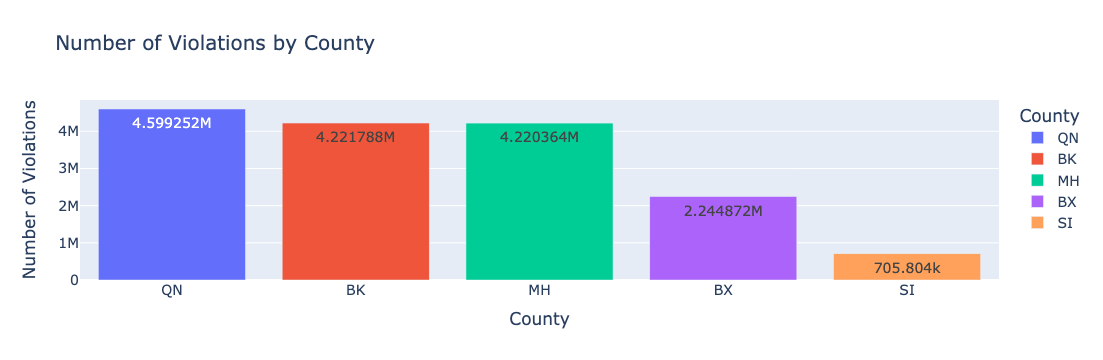

In [88]:
# # Plot violations by County


# Group by county and count violations
county_counts = df['county_standardized'].value_counts().reset_index()
county_counts.columns = ['county_standardized', 'Violations']

# Create the bar chart
fig1 = px.bar(
    county_counts,
    x='county_standardized',
    y='Violations',
    title='Number of Violations by County',
    labels={'county_standardized': 'County', 'Violations': 'Number of Violations'},
    color='county_standardized',  # Color bars by county
    text_auto=True  # Show values on bars
)

# Improve layout
fig1.update_layout(
    xaxis_title='County',
    yaxis_title='Number of Violations',
    xaxis={'categoryorder':'total descending'},  # Sort by count (highest first)
    bargap=0.2,  # Gap between bars
    font=dict(size=14),
)

import plotly.io as pio

html_snippet = pio.to_html(fig1, full_html=False, include_plotlyjs='cdn')

# Save to file
with open("violations_county_embed_snippet.html", "w") as f:
    f.write(html_snippet)


# Display the chart
fig1.show()

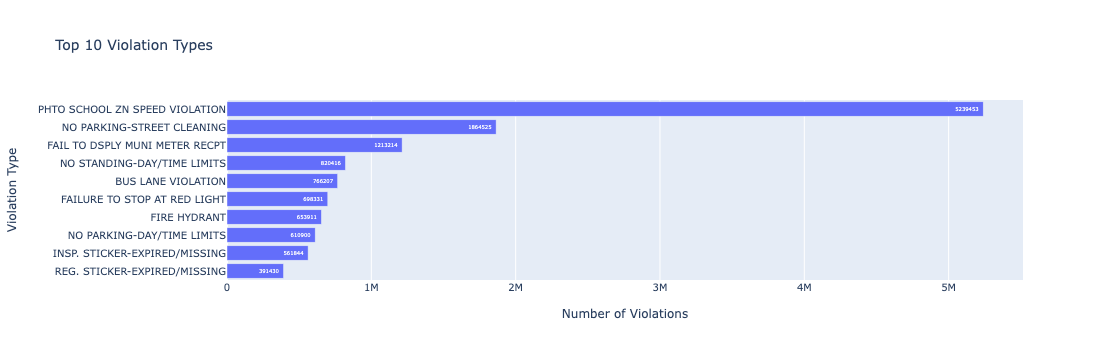

In [90]:
# Group by Violation type and count
violation_counts = df['Violation'].value_counts().reset_index()
violation_counts.columns = ['Violation', 'Violations']

# Limit to Top 10
top_10 = violation_counts.head(10)

# Create horizontal bar chart
fig = px.bar(
    top_10,
    x='Violations',
    y='Violation',
    orientation='h',
    title='Top 10 Violation Types',
    labels={'Violation': 'Violation Type', 'Violations': 'Number of Violations'},
    text='Violations'
)

# Improve layout
fig.update_layout(
    yaxis=dict(categoryorder='total ascending'),  # Makes the largest bar appear at top
    font=dict(size=10),
)

html_snippet = pio.to_html(fig, full_html=False, include_plotlyjs='cdn')

# Save to file
with open("top10_violations_type_embed_snippet.html", "w") as f:
    f.write(html_snippet)

# Display the chart
fig.show()

/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/2561436153.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



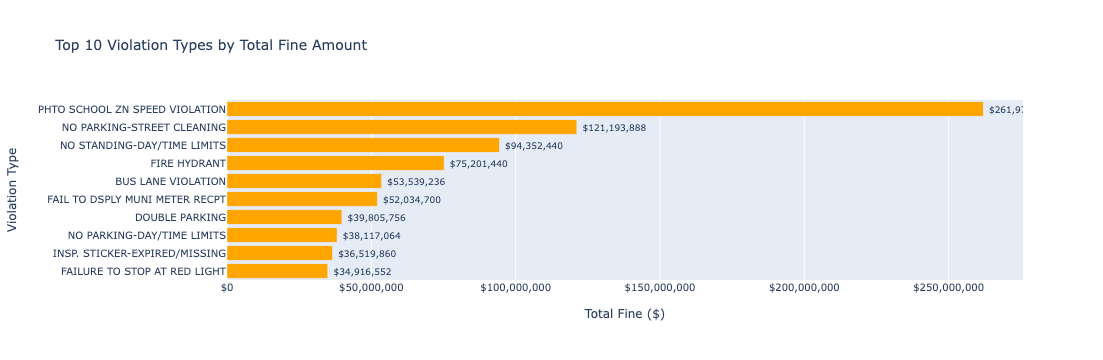

In [92]:
import plotly.express as px

# Group by Violation type and sum Fine Amount
violation_fines = df.groupby("Violation")["Fine Amount"].sum().reset_index()

# Sort and take Top 10
top_10_fines = violation_fines.sort_values(by="Fine Amount", ascending=False).head(10)

# Create horizontal bar chart in orange
fig = px.bar(
    top_10_fines,
    x="Fine Amount",
    y="Violation",
    orientation="h",
    title="Top 10 Violation Types by Total Fine Amount",
    labels={"Violation": "Violation Type", "Fine Amount": "Total Fine ($)"},
    text="Fine Amount",
    color_discrete_sequence=["orange"]  # set bar color
)

# Largest bar at top
fig.update_layout(
    yaxis=dict(categoryorder='total ascending'),
    font=dict(size=10),
)

# Format y-axis values (if x-axis is fine amount, this is x-axis)
fig.update_layout(
    yaxis=dict(categoryorder='total ascending'),
    font=dict(size=10),
    xaxis_tickformat='$,.0f'  # Show as $1,000 format, no decimals
)

# Format the bar labels (on the bars themselves)
fig.update_traces(
    texttemplate='$%{text:,.0f}',  # Dollar sign + commas, no decimals
    textposition='outside'
)

#Export HTML
html_snippet = pio.to_html(fig, full_html=False, include_plotlyjs='cdn')

# Save and name HTML file
with open("top10_violations_amount_embed_snippet.html", "w") as f:
    f.write(html_snippet)


# Show the chart
fig.show()

## Fine Payment Rates

In [27]:
# Step 1: Group by Violation and sum Fine Amount and Amount Due
violation_sums = (
    df.groupby("Violation")[["Fine Amount", "Amount Due"]]
    .sum()
    .reset_index()
)

# Step 2: Calculate Percent Unpaid
violation_sums["Percent Unpaid"] = violation_sums["Amount Due"] / violation_sums["Fine Amount"]

# Step 3: Get top 10 by Percent Unpaid
top_10_unpaid = violation_sums.sort_values(by="Percent Unpaid", ascending=False).head(10)

/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/2006657579.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [28]:
styled_table = (
    top_10_unpaid
    .style
    .format({
        "Percent Unpaid": "{:.0%}",              # 47%
        "Fine Amount": "${:,.0f}",               # $50,000
        "Amount Due": "${:,.0f}"                 # $12,345
    })
    .background_gradient(subset=["Percent Unpaid"], cmap="OrRd")
)
styled_table


,Violation,Fine Amount,Amount Due,Percent Unpaid
9,DETACHED TRAILER,"$1,342,660","$1,490,034",111%
34,MISSING EQUIPMENT,"$197,415","$207,246",105%
39,NO MATCH-PLATE/STICKER,"$1,194,170","$1,027,663",86%
15,EXPIRED METER,$300,$240,80%
67,OTHER,"$333,845","$266,239",80%
75,PKG IN EXC. OF LIM-COMM MTR ZN,$165,$120,73%
31,MARGINAL STREET/WATER FRONT,$450,$327,73%
68,OVERNIGHT TRACTOR TRAILER PKG,"$1,418,942","$991,545",70%
90,VEH-SALE/WSHNG/RPRNG/DRIVEWAY,"$1,315",$881,67%
89,VACANT LOT,"$1,870","$1,194",64%


In [29]:
# Step 1: Group by Violation and sum Fine and Due
violation_sums = (
    df.groupby("Violation")[["Fine Amount", "Amount Due"]]
    .sum()
    .reset_index()
)

# Step 2: Calculate Percent Paid
violation_sums["Percent Paid"] = 1 - (violation_sums["Amount Due"] / violation_sums["Fine Amount"])

# Step 3: Sort by Percent Paid (descending) and select top 10
top_10_paid = violation_sums.sort_values(by="Percent Paid", ascending=False).head(10)

# Step 4: Style the table
styled_paid_table = (
    top_10_paid
    .style
    .format({
        "Percent Paid": "{:.0%}",
        "Fine Amount": "${:,.0f}",
        "Amount Due": "${:,.0f}"
    })
    .background_gradient(subset=["Percent Paid"], cmap="Greens")
)

# Show the styled table
styled_paid_table


/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/279209720.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Violation,Fine Amount,Amount Due,Percent Paid
66,OT PARKING-MISSING/BROKEN METR,$100,$0,100%
33,MISCELLANEOUS,$305,$0,100%
40,NO OPERATOR NAM/ADD/PH DISPLAY,"$1,545",$0,100%
18,EXPIRED MUNI MTR-COMM MTR ZN,"$2,144,785","$164,681",92%
19,FAIL TO DISP. MUNI METER RECPT,"$15,125,310","$1,744,458",88%
72,PCKP DSCHRGE IN PRHBTD ZONE,"$216,545","$27,067",88%
60,NO STD(EXC TRKS/GMTDST NO-TRK),"$42,625","$5,733",87%
35,MISUSE PARKING PERMIT,"$423,135","$60,216",86%
24,FRAUDULENT USE PARKING PERMIT,"$858,780","$126,674",85%
0,ALTERING INTERCITY BUS PERMIT,"$12,940","$2,409",81%


In [30]:
# Group and calculate Percent Unpaid
violation_unpaid = (
    df.groupby("Violation")[["Fine Amount", "Amount Due"]]
    .sum()
    .reset_index()
)

violation_unpaid["Percent Unpaid"] = violation_unpaid["Amount Due"] / violation_unpaid["Fine Amount"]

# Filter for violations with total Fine ≥ $1,000,000
violation_unpaid_filtered = violation_unpaid[violation_unpaid["Fine Amount"] >= 1_000_000]

# Sort and select Top 10 by Percent Unpaid
top_10_unpaid_filtered = violation_unpaid_filtered.sort_values(by="Percent Unpaid", ascending=False).head(10)

# Style the table
styled_unpaid_filtered = (
    top_10_unpaid_filtered
    .style
    .format({
        "Percent Unpaid": "{:.0%}",
        "Fine Amount": "${:,.0f}",
        "Amount Due": "${:,.0f}"
    })
    .background_gradient(subset=["Percent Unpaid"], cmap="OrRd")
)

styled_unpaid_filtered

/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/4145552306.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Violation,Fine Amount,Amount Due,Percent Unpaid
9,DETACHED TRAILER,"$1,342,660","$1,490,034",111%
39,NO MATCH-PLATE/STICKER,"$1,194,170","$1,027,663",86%
68,OVERNIGHT TRACTOR TRAILER PKG,"$1,418,942","$991,545",70%
92,VIN OBSCURED,"$2,557,120","$1,367,878",53%
25,FRONT OR BACK PLATE MISSING,"$15,181,074","$7,587,577",50%
29,INSP. STICKER-EXPIRED/MISSING,"$36,519,860","$16,345,534",45%
79,REG. STICKER-EXPIRED/MISSING,"$25,443,230","$10,156,061",40%
58,NO STANDING-OFF-STREET LOT,"$11,834,415","$4,641,306",39%
23,FIRE HYDRANT,"$75,201,440","$29,477,184",39%
76,PLTFRM LFTS LWRD POS COMM VEH,"$5,340,015","$2,074,106",39%


In [31]:
# Reuse the same base grouped data
violation_paid = violation_unpaid.copy()

# Calculate Percent Paid
violation_paid["Percent Paid"] = 1 - violation_paid["Percent Unpaid"]

# Filter and sort
violation_paid_filtered = violation_paid[violation_paid["Fine Amount"] >= 1_000_000]
top_10_paid_filtered = violation_paid_filtered.sort_values(by="Percent Paid", ascending=False).head(10)

# Style the table
styled_paid_filtered = (
    top_10_paid_filtered
    .style
    .format({
        "Percent Paid": "{:.0%}",
        "Fine Amount": "${:,.0f}",
        "Amount Due": "${:,.0f}"
    })
    .background_gradient(subset=["Percent Paid"], cmap="Greens")
)

#Export HTML
html_snippet = pio.to_html(fig, full_html=False, include_plotlyjs='cdn')

# Save and name HTML file
with open("top10_mos-paid_violations_embed_snippet.html", "w") as f:
    f.write(html_snippet)

styled_paid_filtered

,Violation,Fine Amount,Amount Due,Percent Unpaid,Percent Paid
18,EXPIRED MUNI MTR-COMM MTR ZN,"$2,144,785","$164,681",0.076782,92%
19,FAIL TO DISP. MUNI METER RECPT,"$15,125,310","$1,744,458",0.115334,88%
12,DOUBLE PARKING-MIDTOWN COMML,"$8,288,970","$1,650,464",0.199116,80%
7,COMML PLATES-UNALTERED VEHICLE,"$2,433,400","$496,996",0.204239,80%
62,NO STOPPING-DAY/TIME LIMITS,"$7,320,110","$1,528,357",0.208789,79%
17,EXPIRED MUNI METER,"$11,849,405","$2,641,667",0.222937,78%
59,NO STANDING-TAXI STAND,"$2,021,700","$453,779",0.224454,78%
46,NO STAND TAXI/FHV RELIEF STAND,"$1,071,845","$244,432",0.228048,77%
94,WEIGH IN MOTION VIOLATION,"$1,303,530","$304,722",0.233767,77%
22,FAILURE TO STOP AT RED LIGHT,"$34,916,552","$8,249,493",0.236263,76%


/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/1783155020.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



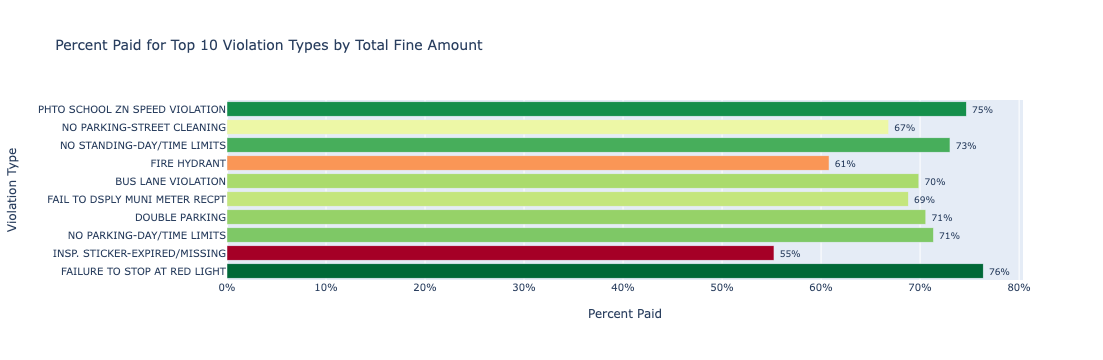

In [96]:
import plotly.express as px

# Step 1: Group by Violation and calculate Percent Paid
violation_paid = (
    df.groupby("Violation")[["Fine Amount", "Amount Due"]]
    .sum()
    .assign(Percent_Paid=lambda d: 1 - (d["Amount Due"] / d["Fine Amount"]))
    .reset_index()
)

# Step 2: Get top 10 violations by total Fine Amount
top_10_fines = violation_paid.sort_values(by="Fine Amount", ascending=False).head(10)

# Step 3: Create sorted y-axis based on Fine Amount order
ordered_violations = top_10_fines.sort_values(by="Fine Amount", ascending=True)["Violation"]

# Step 4: Create horizontal bar chart
fig = px.bar(
    top_10_fines,
    x="Percent_Paid",
    y="Violation",
    orientation="h",
    text="Percent_Paid",
    title="Percent Paid for Top 10 Violation Types by Total Fine Amount",
    labels={"Percent_Paid": "Percent Paid", "Violation": "Violation Type"},
    color="Percent_Paid",
    color_continuous_scale="RdYlGn"
)

# Step 5: Sort bars by Fine Amount
fig.update_layout(
    yaxis=dict(categoryorder="array", categoryarray=ordered_violations),
    xaxis_tickformat=".0%",
    font=dict(size=10),
    coloraxis_showscale=False
)

# Step 6: Add percentage labels
fig.update_traces(
    texttemplate='%{text:.0%}',
    textposition='outside'
)


#Export HTML
html_snippet = pio.to_html(fig, full_html=False, include_plotlyjs='cdn')

# Save and name HTML file
with open("top10_violations_amount_paid-percentage_embed_snippet.html", "w") as f:
    f.write(html_snippet)

fig.show()


## Agency Analysis

/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/489446463.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



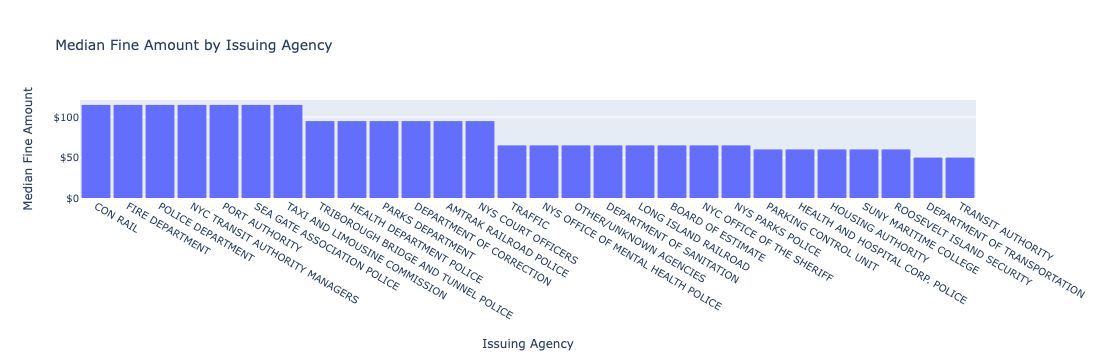

In [98]:
import plotly.express as px

# Step 1: Calculate median Fine Amount by Issuing Agency
median_fines = df.groupby("Issuing Agency")["Fine Amount"].median().reset_index()

# Step 2: Sort by descending median
median_fines = median_fines.sort_values(by="Fine Amount", ascending=False)

# Step 3: Create vertical bar chart
fig = px.bar(
    median_fines,
    x="Issuing Agency",
    y="Fine Amount",
    title="Median Fine Amount by Issuing Agency",
    hover_data={"Fine Amount": ":.0f"},  # Format tooltip as whole number
)

# Step 4: Layout adjustments
fig.update_traces(
    marker_line_width=0,  # no outline on bars
    hovertemplate='<b>%{x}</b><br>Median Fine: $%{y:,.0f}<extra></extra>',  # custom tooltip
    text=None  # remove any text labels from bars
)

fig.update_layout(
    bargap=0.1,  # small space between bars
    xaxis={'categoryorder': 'total descending'},
    font=dict(size=10),
    yaxis_tickformat='$,',
    yaxis_title="Median Fine Amount"
)

#Export HTML
html_snippet = pio.to_html(fig, full_html=False, include_plotlyjs='cdn')

# Save and name HTML file
with open("median_fine_amount_agency_embed_snippet.html", "w") as f:
    f.write(html_snippet)


fig.show()


/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/1620228229.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



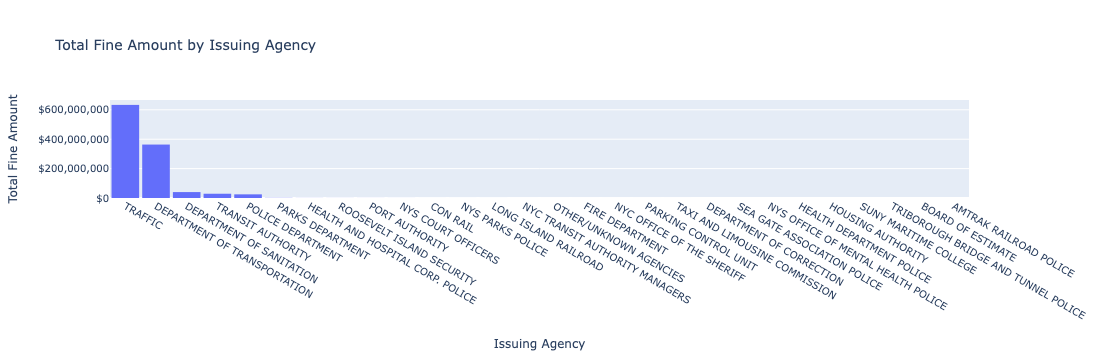

In [100]:
import plotly.express as px

# Step 1: Group by Issuing Agency and sum Fine Amount
total_fines = df.groupby("Issuing Agency")["Fine Amount"].sum().reset_index()

# Step 2: Sort in descending order
total_fines = total_fines.sort_values(by="Fine Amount", ascending=False)

# Step 3: Create the bar chart
fig = px.bar(
    total_fines,
    x="Issuing Agency",
    y="Fine Amount",
    title="Total Fine Amount by Issuing Agency",
    hover_data={"Fine Amount": ":.0f"}  # tooltip format: no decimals
)

# Step 4: Format layout and tooltips
fig.update_traces(
    marker_line_width=0,
    text=None,
    hovertemplate='<b>%{x}</b><br>Total Fines: $%{y:,.0f}<extra></extra>'
)

fig.update_layout(
    bargap=0.1,
    xaxis={'categoryorder': 'total descending'},
    font=dict(size=10),
    yaxis_tickformat='$,',
    yaxis_title="Total Fine Amount"
)

#Export HTML
html_snippet = pio.to_html(fig, full_html=False, include_plotlyjs='cdn')

# Save and name HTML file
with open("total_fine_amount_agency_embed_snippet.html", "w") as f:
    f.write(html_snippet)

fig.show()

## Monthly Charts

In [37]:
# Ensure Issue Date is datetime
df["Issue Date"] = pd.to_datetime(df["Issue Date"], errors="coerce")

# Create a 'Month' column in YYYY-MM format
df["Month"] = df["Issue Date"].dt.to_period("M").astype(str)

### Violations by Month

In [39]:
# Count violations by month
monthly_counts = df.groupby("Month").size().reset_index(name="Violation Count")

fig1 = px.line(
    monthly_counts,
    x="Month",
    y="Violation Count",
    title="Number of Violations by Month",
    markers=True,
    line_shape="linear",
    line_dash_sequence=["solid"],
)

fig1.update_traces(line_color="dodgerblue")
fig1.update_layout(
    xaxis_title="Month",
    yaxis_title="Violations",
    yaxis_range=[1_000_000, 1_500_000]  # adjust this as needed
)

fig1.show()

In [40]:
# Ensure datetime format and extract Month
df["Issue Date"] = pd.to_datetime(df["Issue Date"], errors="coerce")
df["Month"] = df["Issue Date"].dt.to_period("M").astype(str)

# Group by Month and Issuing Agency to count violations
monthly_by_agency = (
    df.groupby(["Month", "Issuing Agency"])
    .size()
    .reset_index(name="Violation Count")
)

# Plot the multi-line chart
fig = px.line(
    monthly_by_agency,
    x="Month",
    y="Violation Count",
    color="Issuing Agency",
    title="Monthly Violation Counts by Issuing Agency",
    markers=True
)

fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Violation Count",
    font=dict(size=10)
)

fig.show()


/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/4164970983.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [41]:
import pandas as pd
import plotly.express as px

# Step 1: Ensure datetime format and create Month column
df["Issue Date"] = pd.to_datetime(df["Issue Date"], errors="coerce")
df["Month"] = df["Issue Date"].dt.to_period("M").astype(str)

# Step 2: Identify top 5 agencies by total violations
top_5_agencies = (
    df["Issuing Agency"]
    .value_counts()
    .head(5)
    .index
    .tolist()
)

# Step 3: Group by Month and Issuing Agency, then filter down
monthly_all = (
    df.groupby(["Month", "Issuing Agency"])
    .size()
    .reset_index(name="Violation Count")
)

# Step 4: Filter grouped data to just top 5 agencies
monthly_top5 = monthly_all[monthly_all["Issuing Agency"].isin(top_5_agencies)]

# Step 5: Plot
fig = px.line(
    monthly_top5,
    x="Month",
    y="Violation Count",
    color="Issuing Agency",
    title="Monthly Violation Counts by Top 5 Issuing Agencies",
    markers=True
)

fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Violation Count",
    font=dict(size=10)
)

fig.show()

/var/folders/_r/13_6z2c15zz2fh0w3xvyy2qr0000gn/T/ipykernel_5764/3905235891.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [42]:
#same viz but now stacked

fig_stacked = px.area(
    monthly_top5,
    x="Month",
    y="Violation Count",
    color="Issuing Agency",
    title="Stacked Monthly Violation Counts (Top 5 Issuing Agencies)"
)

fig_stacked.update_layout(
    xaxis_title="Month",
    yaxis_title="Cumulative Violation Count",
    font=dict(size=10)
)

fig_stacked.show()

### Other Monthly Metrics

In [44]:
# Total Fine Amount by Month

monthly_fines = df.groupby("Month")["Fine Amount"].sum().reset_index()

fig2 = px.line(
    monthly_fines,
    x="Month",
    y="Fine Amount",
    title="Total Fine Amount by Month",
    markers=True
)

fig2.update_traces(line_color="darkorange")
fig2.update_layout(xaxis_title="Month", yaxis_title="Total Fine ($)", yaxis_tickformat="$,.0f", yaxis_range=[70_000_000, 100_000_000]  # adjust this as needed
)
fig2.show()

In [45]:
# Percent Unpaid by Month

monthly_unpaid = (
    df.groupby("Month")[["Fine Amount", "Amount Due"]]
    .sum()
    .reset_index()
)

monthly_unpaid["Percent Unpaid"] = monthly_unpaid["Amount Due"] / monthly_unpaid["Fine Amount"]

fig3 = px.line(
    monthly_unpaid,
    x="Month",
    y="Percent Unpaid",
    title="Percent Unpaid by Month",
    markers=True
)

fig3.update_traces(line_color="crimson")
fig3.update_layout(
    xaxis_title="Month",
    yaxis_title="Unpaid %",
    yaxis_tickformat=".0%"
)
fig3.show()

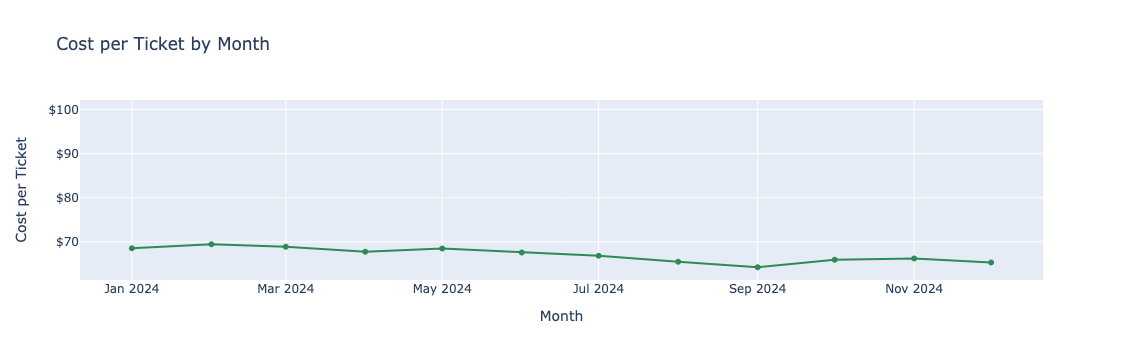

In [46]:
# Cost per ticket by month

monthly_metrics = (
    df.groupby("Month")[["Fine Amount", "Amount Due"]]
    .sum()
    .reset_index()
)

# Add ticket count
monthly_metrics["Ticket Count"] = df.groupby("Month").size().values
monthly_metrics["Cost Per Ticket"] = monthly_metrics["Fine Amount"] / monthly_metrics["Ticket Count"]

fig4 = px.line(
    monthly_metrics,
    x="Month",
    y="Cost Per Ticket",
    title="Cost per Ticket by Month",
    markers=True
)

fig4.update_traces(line_color="seagreen")
fig4.update_layout(
    xaxis_title="Month",
    yaxis_title="Cost per Ticket",
    yaxis_tickformat="$,.0f"
)
fig.update_yaxes(range=[0, 80])
fig4.show()